**Problem to solve: predict how many calories were burned during a workout**

*For data scientist its all about reducing error in prediction.*

Correlation of column and target varible
1. Body_Temp is related to calories because the process creates heat and maintains a healthy baseline internal temperature (https://www.forhers.com/blog/how-to-raise-core-body-temperature-for-weight-loss)
2. Heart_Rate is related to calories because heart beats faster means muscle need more oxygen-rich blood and the body uses calorie to keep up with the extra oxygen needed (https://www.coospo.com/blogs/knowledge/calories-burned-by-heart-rate-understanding-the-connection?srsltid=AfmBOoqn33saM4wUE6pgDOfI-TY7ojgJB_SzwTnhLiMDI1fjusd0pn0_)
3. Duration is affecting calorie but up to one time because low to moderate lead to higher calorie burn but high activity some kind of conserving energy it has (https://magazine.scienceconnected.org/2021/03/more-exercise-doesnt-always-burn-more-calories/)
4. Weight does affect calorie because heavier person need more energy to move the body (https://www.livestrong.com/article/300582-do-fat-people-burn-more-calories/)
5. Height affect calorie because higher metabloc rate than short people (https://sportcoaching.co.nz/do-taller-people-burn-more-calories/)
6. Sex has affection to calorie because larger muscle mass (https://www.everydayhealth.com/fitness/factors-that-can-affect-how-many-calories-you-burn/)
7. Age do affect calorie because key hormone that promote protein systhesis become more resistant as getting older (https://www.everydayhealth.com/fitness/factors-that-can-affect-how-many-calories-you-burn/)

In [18]:
import pandas as pd, seaborn as sns, numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

In [2]:
data_train = pd.read_csv('train.csv')
data_train.head(3)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0


In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [4]:
data_test = pd.read_csv('test.csv')
data_test.head(3)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4


In [5]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          250000 non-null  int64  
 1   Sex         250000 non-null  object 
 2   Age         250000 non-null  int64  
 3   Height      250000 non-null  float64
 4   Weight      250000 non-null  float64
 5   Duration    250000 non-null  float64
 6   Heart_Rate  250000 non-null  float64
 7   Body_Temp   250000 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 15.3+ MB


In [38]:
# Conversion constants
KG_TO_POUND = 2.20462
CM_TO_INCH = lambda x: x / 2.54

# Initialize encoder
le = LabelEncoder()

# Unified BMR & RMR calculator
def calculate_bmr_rmr(row):
    sex = row['Sex']
    weight_kg = row['Weight']
    height_cm = row['Height']
    age = row['Age']
    
    weight_pounds = weight_kg * KG_TO_POUND
    height_inches = height_cm / 2.54

    if sex == 1:  # Male
        bmr = 88.362 + (13.397 * weight_kg) + (4.799 * height_cm) - (5.677 * age)
        rmr = (4.38 * weight_pounds) + (14.55 * height_inches) - (5.08 * age) + 260
    elif sex == 0:  # Female
        bmr = 447.593 + (9.247 * weight_kg) + (3.098 * height_cm) - (4.330 * age)
        rmr = (3.35 * weight_pounds) + (15.42 * height_inches) - (2.31 * age) + 43
    else:
        bmr = rmr = None

    return pd.Series([bmr, rmr])

def estimate_met_vectorized(age, hr_exercise, sex, default_vo2max_male=45, default_vo2max_female=38):
    hr_max = 220 - age
    hr_index = hr_exercise / hr_max
    vo2max = np.where(sex == 1, default_vo2max_male, default_vo2max_female)

    # Estimate VO2 and MET
    vo2 = hr_index * vo2max
    met = vo2 / 3.5

    return {
        'Estimated_MET': np.round(met, 2)
    }

# Age grouping function
def age_grouping(df):
    bins = [17, 64, float('inf')]
    labels = ['Adults', 'Older Adults']
    df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
    df['AgeGroups'] = le.fit_transform(df['AgeGroup'])
    return df

def basic_preprocessing(dataset, isDataTrain=False):
    le = LabelEncoder()
    scaler = StandardScaler()
    dataset_prep = dataset.copy()
    dataset_prep.drop_duplicates(inplace=True)
    dataset_prep.drop('id', axis=1, inplace=True)
    le.fit(dataset_prep.Sex.drop_duplicates())
    dataset_prep.Sex = le.transform(dataset_prep.Sex)
    
    dataset_prep['Weight_pounds'] = dataset_prep['Weight'] * KG_TO_POUND
    dataset_prep['Height_inches'] = dataset_prep['Height'].apply(CM_TO_INCH)
    dataset_prep[['BMR', 'RMR']] = dataset_prep.apply(calculate_bmr_rmr, axis=1)
    met_results = estimate_met_vectorized(dataset_prep['Age'], dataset_prep['Heart_Rate'], dataset_prep['Sex'])
    dataset_prep['MET'] = met_results['Estimated_MET']
    dataset_prep = age_grouping(dataset_prep)
    dataset_prep['BMI'] = dataset_prep['Weight'] / (dataset_prep['Height'] / 100) ** 2
    
    cols_to_scale = ['Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMR', 'RMR', 'MET', 'BMI']
    
    if isDataTrain:
        cols_to_scale.append('Calories')
    
    scaled_data = dataset_prep.copy()
    scaled_data[cols_to_scale] = scaler.fit_transform(scaled_data[cols_to_scale])
    
    column_reposition = ['Sex', 'Age', 'AgeGroups', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp',
       'Weight_pounds', 'Height_inches', 'BMR', 'RMR', 'MET',
       'AgeGroup', 'BMI']
    
    if isDataTrain:
        column_reposition.append('Calories')
        scaled_data = scaled_data[column_reposition]
    else:
        scaled_data = scaled_data[column_reposition]
    
    return scaled_data

In [39]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

data_train = basic_preprocessing(data_train, isDataTrain=True)
data_test = basic_preprocessing(data_test)

In [ ]:
# def eda_purpose(dataset):
#     dataset_prep = dataset.copy()
#     le = LabelEncoder()
    
#     try:
#         # changing format of Sex column from 'female' to '0', 'male' to '1'
#         le.fit(dataset_prep.Sex.drop_duplicates())
#         dataset_prep.Sex = le.transform(dataset_prep.Sex)
        
#         # dropping duplicate and remove unused column
#         dataset_prep.drop('id', axis=1, inplace=True)   
#         dataset_prep.drop_duplicates(inplace=True)
#         dataset_prep.reset_index(inplace=True, drop=True)
#     except:
#         print('error')
    
#     return dataset_prep

In [ ]:
# data_train = pd.read_csv('train.csv')
# data_test = pd.read_csv('test.csv')

# data_train = eda_purpose(data_train)
# data_test = eda_purpose(data_test)

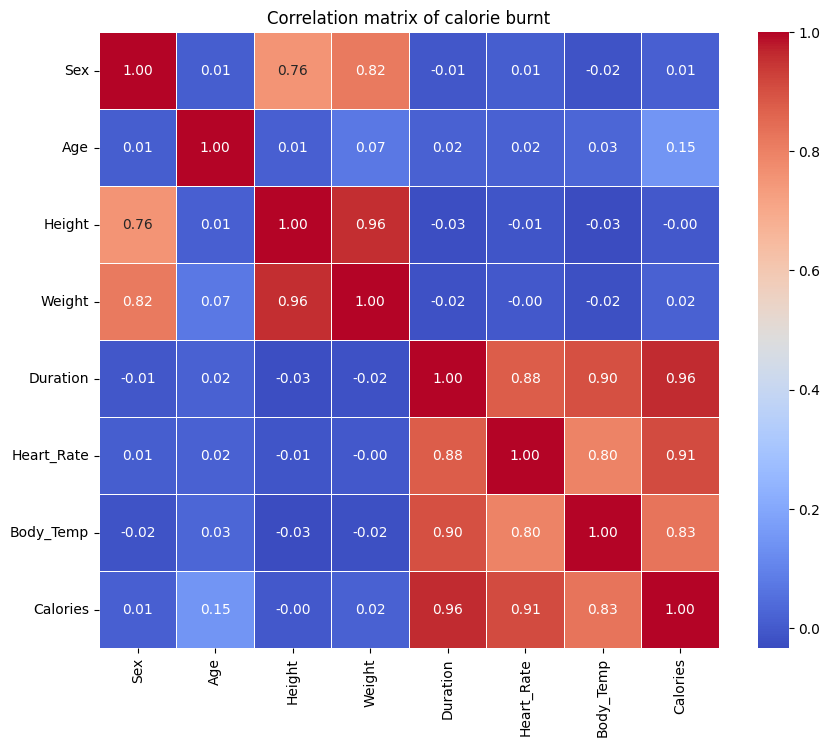

In [11]:
def correlation_visualization(dataset):
    corr_matrix = dataset.corr()

    plt.figure(figsize=(10,8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation matrix of calorie burnt')
    plt.show()
    
correlation_visualization(data_train)

**Lets plot correlation each column to see relationship**

Whoa, in this visualization we see 
1. duration, heart_rate, body_temp correlate so much with calories burnt. They have strong correlation, this means the higher duration the more calories burnt. 
2. Other variable (sex, age, height, weight) has weak to no correlation to calorie, which the more higher calorie the less they follow the same pattern as calorie burnt

lets dig down these strong correlation columns

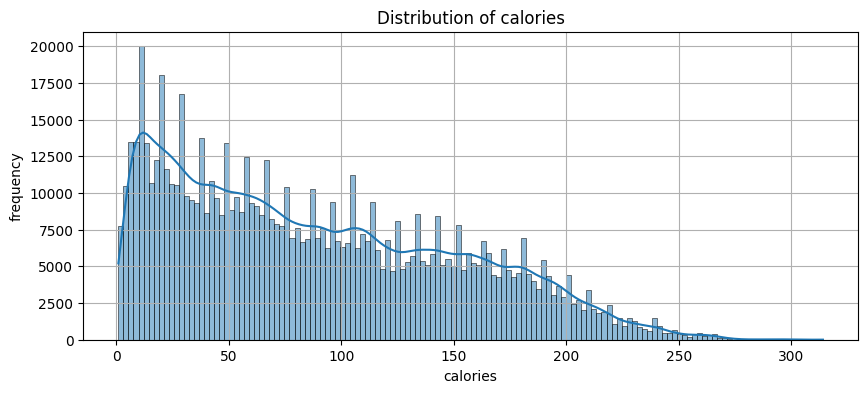

In [12]:
plt.figure(figsize=(10,4))
sns.histplot(data_train['Calories'], kde=True)
plt.title(f'Distribution of calories')
plt.xlabel('calories')
plt.ylabel('frequency')
plt.grid(True)
plt.show()

Article refference:
- https://fitliferegime.com/exercise-calories-burned-calculator/#:~:text=Several%20factors%20influence%20calorie%20burn%20during%20exercise%3A%20body,mass%2C%20and%20overall%20health%20can%20impact%20caloric%20expenditure
- https://www.fitpaa.com/blog/are-there-any-specific-exercises-or-routines-for-different-age-groups

Article info:
- Calorie = Time (hour) x 60 x MET x 3.5 x Body weight (kilogram) / 200
- Activity with engage multiple muscle group and maintain elevated heart rates can burn much calorie
- Grouping idea: Light exercise (2-4.9 METs), moderate (5.0-7.9 METs), vigorous (8.0+ METs)
- EPOC (afterburn effect), not sure what it is
- Several factors influence calorie burn during exercise: body weight, exercise intensity (MET value), duration, fitness level, and exercise type. Additionally, factors like age, muscle mass, and overall health can impact caloric expenditure
- Group age 5-17 consider children, group age 18-30 consider young adult, group age 31-64 consider adult, group age >65 consider older adult 

Cut the visualization, lets try to make new feature

In [40]:
data_train

,Sex,Age,AgeGroups,Height,Weight,Duration,Heart_Rate,Body_Temp,Weight_pounds,Height_inches,BMR,RMR,MET,AgeGroup,BMI,Calories
0,1,36,0,1.115235,0.490201,1.266324,0.583714,1.235772,180.77884,74.409449,0.853821,0.935178,0.654741,Adults,-0.939009,0.989132
1,0,64,1,-0.912137,-1.083172,-0.888309,-1.109436,-0.431163,132.27720,64.173228,-1.340508,-1.215197,-0.457574,Older Adults,-1.185799,-0.869982
2,0,51,0,-1.068088,-0.797104,-1.008011,-1.215258,-0.302938,141.09568,63.385827,-1.050670,-1.051681,-0.964946,Adults,0.208818,-0.950116
3,1,20,0,1.349162,1.062337,1.146622,1.007002,0.851095,198.41580,75.590551,1.560776,1.540955,0.352269,Adults,0.025968,0.828864
4,0,38,0,-0.678209,-1.011655,1.146622,0.689536,0.722869,134.48182,65.354331,-0.904093,-0.919891,-0.301460,Adults,-1.480887,0.925025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,1,28,0,1.427138,1.562956,1.745131,1.959399,1.107547,213.84814,75.984252,1.737717,1.653626,1.210898,Adults,1.102455,2.271280
749996,0,64,1,-0.756185,-0.868621,0.308709,-0.368683,0.594643,138.89106,64.960630,-1.227554,-1.096954,0.010769,Older Adults,-0.816723,0.123683
749997,1,60,0,-0.990113,-0.582554,1.625430,1.853577,1.107547,147.70954,63.779528,-0.699764,-0.517698,2.625685,Adults,0.764124,2.127038
749998,1,45,0,0.569404,1.133854,0.189007,0.689536,0.338192,200.62042,71.653543,0.973265,0.938928,1.074298,Adults,2.049687,0.332032


In [41]:
data_train.drop(axis=1, inplace=True, columns=['AgeGroup', 'Weight_pounds', 'Height_inches', 'RMR'])

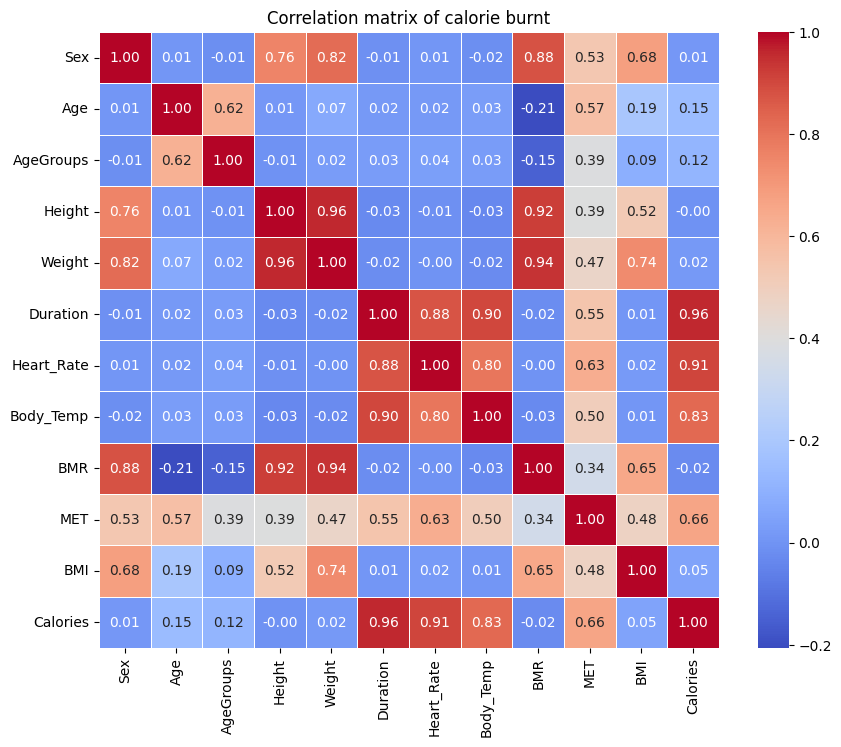

In [42]:
correlation_visualization(data_train)